In [3]:
!splitcode --version
!kallisto version
!fastq-dump --version

splitcode, version 0.30.0
kallisto, version 0.51.1

fastq-dump : 3.2.1



In [2]:
# Found at https://www.ncbi.nlm.nih.gov/sra/SRX23254919[accn] 
# Retrieve SRA 10x Data
!fastq-dump --outdir FASTA --gzip --skip-technical  --readids --dumpbase --split-files --clip --read-filter pass SRR27585872

Rejected 37241848 READS because of filtering out non-biological READS
Read 18620924 spots for SRR27585872
Written 18620924 spots for SRR27585872


In [4]:
# Change names of file so easier to read
!mv FASTA/SRR27585872_pass_3.fastq.gz FASTA/raw_10x_R1.fastq.gz
!mv FASTA/SRR27585872_pass_4.fastq.gz FASTA/raw_10x_R2.fastq.gz

In [5]:
# Download mouse genome. This experiment used C57BL/6N (Black 6) mice, so we can use a general reference genome. 
!kb ref -d mouse -i index.idx -g t2g.txt

[2025-07-09 22:49:08,907]    INFO [download] Skipping download because some files already exist. Use the --overwrite flag to overwrite.


In [1]:
# Perform pseudoalignment of 10x reads
!kb count --overwrite --h5ad -i index.idx -g t2g.txt -x 10XV3 -o 10x_out FASTA/raw_10x_R1.fastq.gz FASTA/raw_10x_R2.fastq.gz

[2025-07-10 09:12:13,352]    INFO [count] Using index index.idx to generate BUS file to 10x_out from
[2025-07-10 09:12:13,352]    INFO [count]         FASTA/raw_10x_R1.fastq.gz
[2025-07-10 09:12:13,353]    INFO [count]         FASTA/raw_10x_R2.fastq.gz
[2025-07-10 09:15:37,988]    INFO [count] Sorting BUS file 10x_out/output.bus to 10x_out/tmp/output.s.bus
[2025-07-10 09:15:41,774]    INFO [count] On-list not provided
[2025-07-10 09:15:41,774]    INFO [count] Copying pre-packaged 10XV3 on-list to 10x_out
[2025-07-10 09:15:42,394]    INFO [count] Inspecting BUS file 10x_out/tmp/output.s.bus
[2025-07-10 09:15:54,910]    INFO [count] Correcting BUS records in 10x_out/tmp/output.s.bus to 10x_out/tmp/output.s.c.bus with on-list 10x_out/10x_version3_whitelist.txt
[2025-07-10 09:16:10,058]    INFO [count] Sorting BUS file 10x_out/tmp/output.s.c.bus to 10x_out/output.unfiltered.bus
[2025-07-10 09:16:13,354]    INFO [count] Generating count matrix 10x_out/counts_unfiltered/cells_x_genes from BU

In [1]:
# Import packages
import anndata
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd
from pybiomart import Server

In [2]:
data = anndata.read_h5ad('10x_out/counts_unfiltered/adata.h5ad')
data.obs['n_genes'] = data.X.astype(bool).sum(axis=1).A1
data.var['n_cells'] = data.X.astype(bool).sum(axis=0).A1
data.obs['n_counts'] = data.X.sum(axis=1).A1

In [3]:
#read in gene names

data.var['gene_codes'] = data.var.index.tolist()

gene_names = []

with open('10x_out/counts_unfiltered/cells_x_genes.genes.names.txt', 'r') as file:
    for line in file:
        gene_names.append(line.strip())

data.var_names = gene_names

# 10x Quality Control

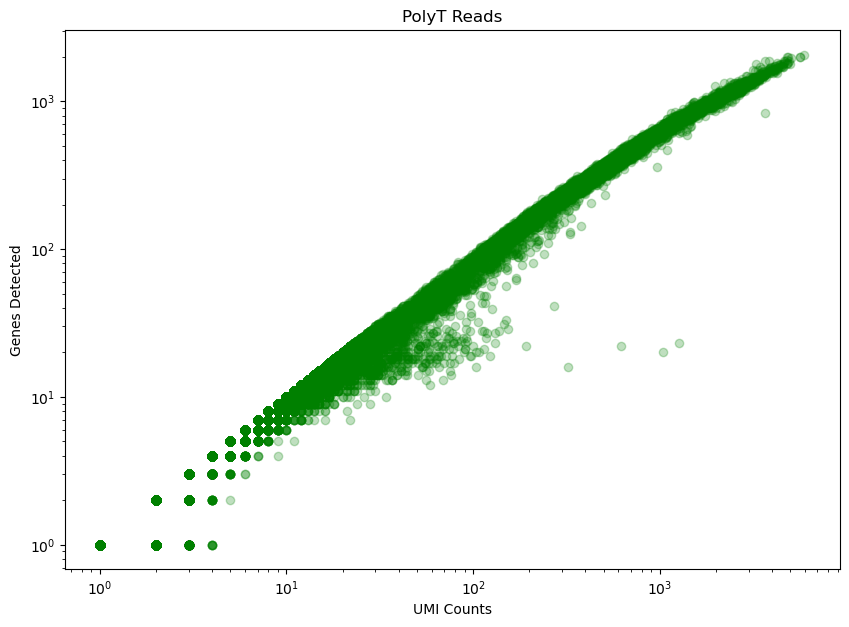

In [4]:
fig, ax = plt.subplots(figsize=(10, 7))

x = np.asarray(data.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(data.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log', nonpositive='clip')
ax.set_title("PolyT Reads")

plt.show()

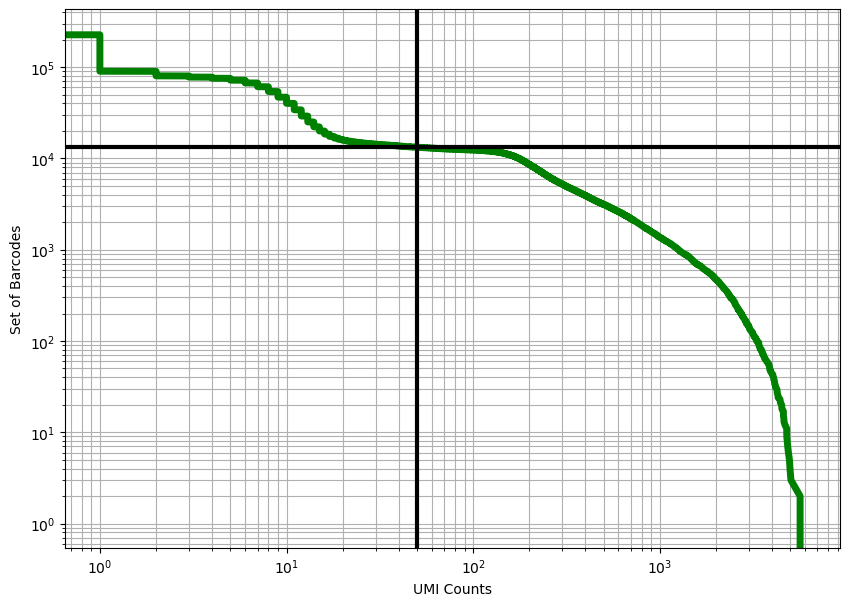

In [5]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
cutoff = 50  #@param {type:"integer"}
knee = np.sort((np.array(data.X.sum(axis=1))).flatten())[::-1]
cell_set = np.arange(len(knee))
num_cells = cell_set[knee > cutoff][::-1][0]

fig, ax = plt.subplots(figsize=(10, 7))


ax.loglog(knee, cell_set, linewidth=5, color="g")
ax.axvline(x=cutoff, linewidth=3, color="k")


ax.axhline(y=num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

In [6]:
print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold")

13,240 cells passed the 50 UMI threshold


In [7]:
server = Server(host='http://www.ensembl.org')
dataset = server.marts['ENSEMBL_MART_ENSEMBL'] \
                .datasets['mmusculus_gene_ensembl']

result = dataset.query(attributes=[
    'ensembl_gene_id_version', 'transcript_biotype'
], filters={'transcript_biotype': ['lncRNA']})

lncRNA_genes = set(data.var["gene_codes"].tolist()).intersection(set(result['Gene stable ID version'].tolist()))

In [8]:
# Identify lncRNA genes
data.var["is_lnc"] = np.full(len(data.var_names), False)
data.var.loc[data.var["gene_codes"].isin(list(lncRNA_genes)), ["is_lnc"]] = True

# mitochondrial genes, "MT-" for human, "Mt-" for mouse
data.var["is_mito"] = data.var_names.str.startswith("Mt")
# ribosomal genes
data.var["is_ribo"] = data.var_names.str.startswith(("Rps", "Rpl"))

mito_counts = data[:, data.var['is_mito']].X.sum(axis=1)
ribo_counts = data[:, data.var['is_ribo']].X.sum(axis=1)
nc_counts = data[:, data.var['is_lnc']].X.sum(axis=1)

# Calculate total counts per cell
total_counts = data.X.sum(axis=1)

# Calculate percent mitochondrial and ribosomal gene expression per cell
data.obs['percent_mito'] = np.array(mito_counts / total_counts * 100).flatten()
data.obs['percent_ribo'] = np.array(ribo_counts / total_counts * 100).flatten()
data.obs['percent_lnc'] = np.array(nc_counts / total_counts * 100).flatten()

data.obs['n_counts'] = data.X.sum(axis=1).A1

/var/folders/lj/692w1y611fg61r1wpr5shd0c0000gn/T/ipykernel_28588/992727035.py:18: RuntimeWarning: invalid value encountered in divide
  data.obs['percent_mito'] = np.array(mito_counts / total_counts * 100).flatten()
/var/folders/lj/692w1y611fg61r1wpr5shd0c0000gn/T/ipykernel_28588/992727035.py:19: RuntimeWarning: invalid value encountered in divide
  data.obs['percent_ribo'] = np.array(ribo_counts / total_counts * 100).flatten()
/var/folders/lj/692w1y611fg61r1wpr5shd0c0000gn/T/ipykernel_28588/992727035.py:20: RuntimeWarning: invalid value encountered in divide
  data.obs['percent_lnc'] = np.array(nc_counts / total_counts * 100).flatten()


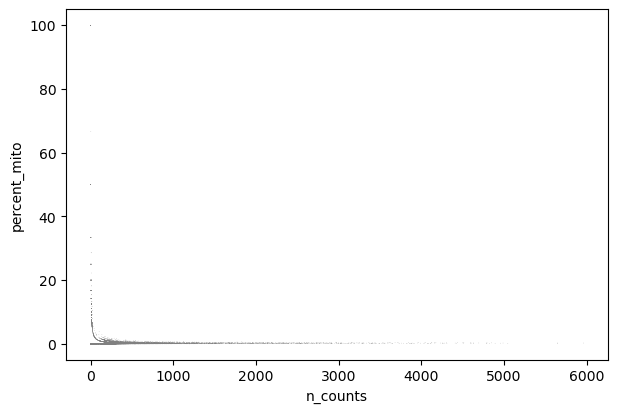

In [9]:
sc.pl.scatter(data, x='n_counts', y='percent_mito')

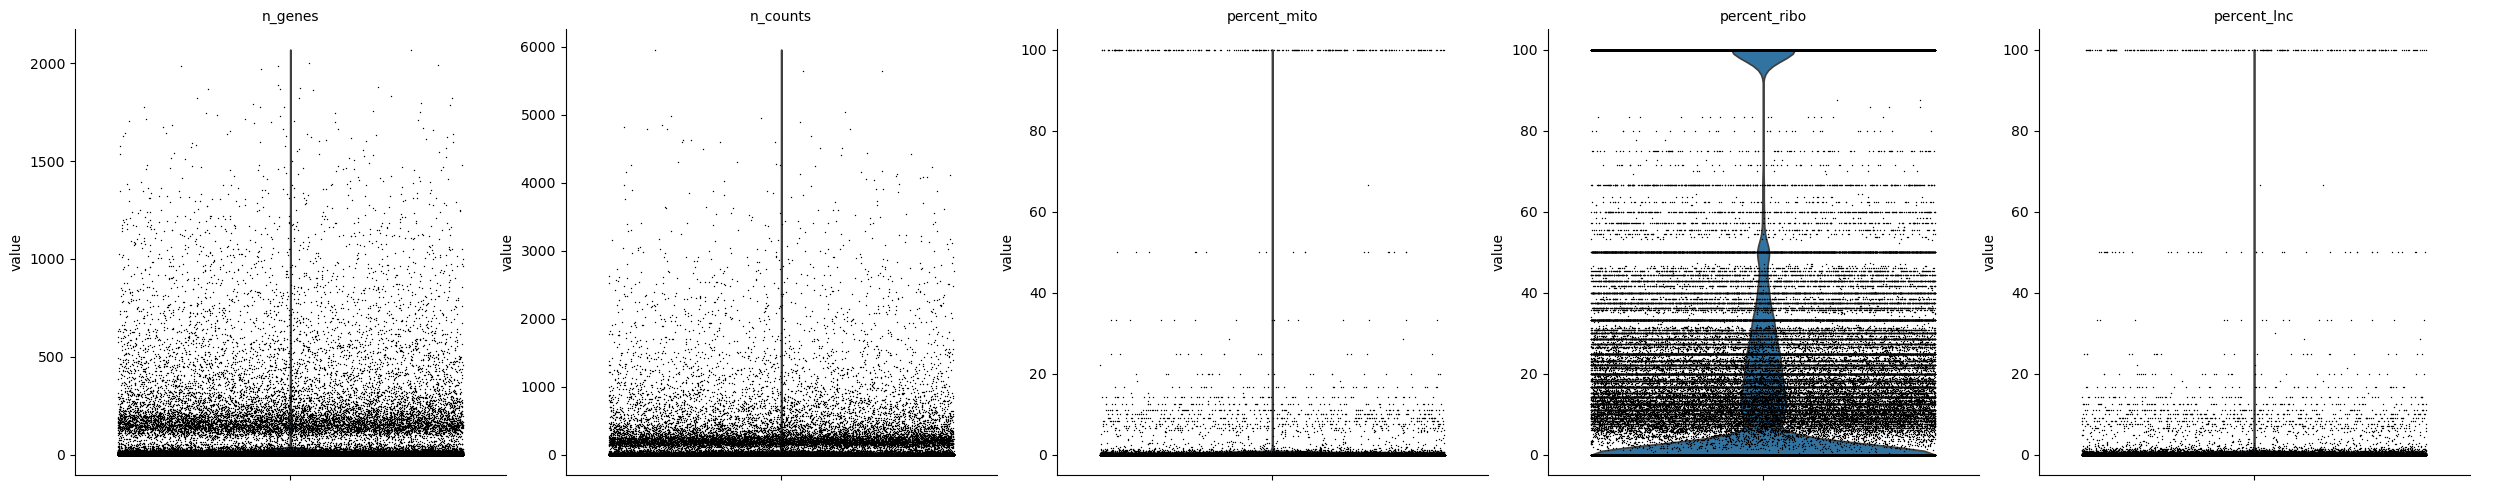

In [10]:
sc.pl.violin(data, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_lnc'], jitter=0.4, multi_panel=True)


# 10x Gene Counts

In [11]:
genes = data.var
top_genes = genes.sort_values(by='n_cells',ascending=False).head(10).index

gene_dist = []

for gene in top_genes:
    gene_dist.append(np.nan_to_num(data[:,gene].X.toarray().transpose()[0] / np.array(data.obs['n_counts'].tolist()) * 100))

/var/folders/lj/692w1y611fg61r1wpr5shd0c0000gn/T/ipykernel_28588/609551392.py:7: RuntimeWarning: invalid value encountered in divide
  gene_dist.append(np.nan_to_num(data[:,gene].X.toarray().transpose()[0] / np.array(data.obs['n_counts'].tolist()) * 100))


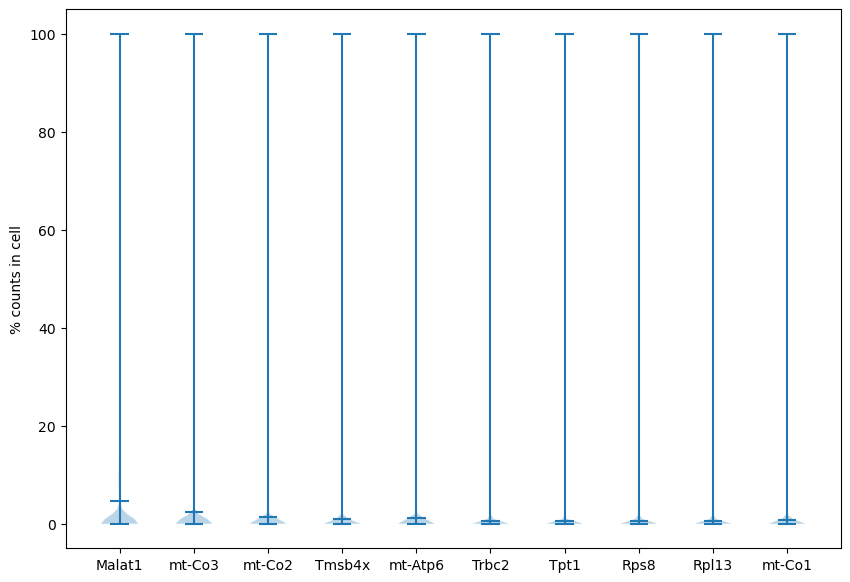

In [12]:
plt.figure(figsize=(10,7))
plt.violinplot(gene_dist, showmeans=True)
plt.xticks(np.arange(1, len(top_genes) + 1), top_genes)
plt.ylabel("% counts in cell")
plt.show()

In [13]:
data.write('processed_10x.h5ad', compression="gzip")